### Версия Python

In [1]:
!python -V

Python 3.12.5


### Импорт необходимых библиотек

In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import glob
import re
import unicodedata
import json
import qbstyles
import pandas as pd
import bs4
import tqdm as tq
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import jupyterlab as jlab

from pathlib import Path
from bs4 import BeautifulSoup
from tqdm import tqdm
from qbstyles import mpl_style

from typing import List, Dict, Optional

mpl_style(dark = False)

### Версии необходимых библиотек

In [3]:
packages = [
    "Pandas", "Matplotlib", "Seaborn", "Qbstyles", "BeautifulSoup", "Tqdm", "JupyterLab"
]

package_objects = [
    pd, matplotlib, sns, qbstyles, bs4, tq, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

pkgs = {"Библиотека": packages, "Версия": versions}
df_pkgs = pd.DataFrame(data = pkgs)
df_pkgs.index.name = "№"
df_pkgs.index += 1

display(df_pkgs)

path_to_reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path_to_reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

,Библиотека,Версия
№,,
1,Pandas,2.2.2
2,Matplotlib,3.9.1
3,Seaborn,0.13.2
4,Qbstyles,0.1.4
5,BeautifulSoup,4.12.3
6,Tqdm,4.66.5
7,JupyterLab,4.2.4


### Предварительная обработка JSON файлов с вакансиями

In [4]:
# Настройка логирования
logging.basicConfig(level = logging.ERROR, format = '%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Определение пути к папке с JSON файлами и директории для сохранения CSV файлов
input_dir = Path("/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/Вакансии/v2/Не_обработанные")
output_dir = Path("/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/Вакансии/v2/Обработанные")

# Настройка параметров для сохранения данных
chunk_size = 5000

def normalize_name(name: str) -> str:
    """Нормализация и форматирование названия файла для корректной обработки"""

    # Приведение к Unicode NFC
    name = unicodedata.normalize('NFC', name)
    # Удаление всех символов, кроме букв, цифр, пробелов, тире и нижних подчеркиваний
    name = re.sub(r'[^\w\s-]', '', name)
    # Замена пробелов и множественных пробелов на нижние подчеркивания
    name = re.sub(r'\s+', '_', name).strip()
    # Приведение к нижнему регистру
    name = name.lower()

    return name

def get_last_dir(file_path: Path) -> str:
    """Получение последней директории"""

    parent_dir = file_path.parent
    last_dir = parent_dir.name
    
    return normalize_name(last_dir)

def clear_directory(directory: Path) -> None:
    """Удаление всех файлов в директории"""
    if not directory.is_dir():
        logger.warning(f"Путь {directory} не является директорией или не существует.")
        return

    for item in directory.iterdir():
        try:
            if item.is_file() or item.is_symlink():
                item.unlink()
                logger.info(f"Файл удален: {item}")
            elif item.is_dir():
                shutil.rmtree(item)
                logger.info(f"Директория удалена: {item}")
        except Exception as e:
            logger.error(f"Ошибка при удалении {item}: {e}")

def extract_text(data: Dict, key: str) -> str:
    """Извлечение текстового поле из словаря, убирая лишние пробелы"""

    return data.get(key, "").strip()

def extract_list_to_string(data: Dict, key: str, sub_key: str) -> str:
    """Преобразование списка словарей в строку, объединяя элементы через запятую"""

    return ", ".join(item.get(sub_key, "").strip() for item in data.get(key, []))

def get_area_name(data: Dict) -> str:
    """Возвращение названия региона или города, удаляя лишние пробелы"""

    if "area" in data and "name" in data["area"]:
        return re.sub(r"\s+", " ", data["area"]["name"]).strip()
    elif "address" in data and "city" in data["address"]:
        return re.sub(r"\s+", " ", data["address"]["city"]).strip()
    return ""

def save_data_to_csv(data_list: List[Dict], file_name: str, output_dir: Path, chunk_count: int) -> None:
    """Сохранение данных в CSV файл с правильной нумерацией"""
    
    # Путь к файлу для первого чанка
    first_chunk_file = output_dir / f"{file_name}.csv"

    # Если это не первый чанк и первый файл уже существует, переименовать его в __1
    if chunk_count == 2 and first_chunk_file.exists():
        new_first_chunk_file = output_dir / f"{file_name}__1.csv"
        first_chunk_file.rename(new_first_chunk_file)
        logger.info(f"Первый файл переименован: {first_chunk_file} -> {new_first_chunk_file}")

    # Определение суффикса для текущего чанка
    file_suffix = f"__{chunk_count}" if chunk_count > 1 else ""
    output_file = output_dir / f"{file_name}{file_suffix}.csv"

    try:
        # Сохранение данных в CSV
        pd.DataFrame(data_list).to_csv(output_file, index = False, encoding = "utf-8-sig", sep = ";")
        logger.info(f"Данные сохранены в файл: {output_file}")
    except Exception as e:
        logger.error(f"Ошибка при сохранении данных в файл {output_file}: {e}")

def process_json_files(input_dir: Path, output_dir: Path, stop_after: Optional[int] = None) -> None:
    """Обработка JSON файлов и сохранение данных в CSV файлы"""
    
    # Создание директории для сохранения файлов, если она не существует
    output_dir.mkdir(parents = True, exist_ok = True)
    # Удаление всех файлов в директории
    clear_directory(output_dir)

    # Получение списка всех JSON файлов
    json_files = list(input_dir.rglob("*.json"))

    with tqdm(json_files, desc = "Обработка JSON файлов", unit = "файл") as pbar:
        data_list = []
        chunk_count = 1
        previous_dir_name = ""
        base_file_name = ""
        
        for cnt, file_path in enumerate(pbar):
            try:
                current_dir_name = get_last_dir(file_path)

                # Если директория изменилась, сохранить данные и начать новый файл
                if current_dir_name != previous_dir_name:
                    if data_list:
                        save_data_to_csv(data_list, previous_dir_name, output_dir, chunk_count)
                        data_list.clear()
                        chunk_count = 1
                    previous_dir_name = current_dir_name

                # Чтение JSON файла
                with file_path.open("r", encoding = "utf-8") as f:
                    data = json.load(f)

                # Извлечение и обработка данных
                id_vacancy = extract_text(data, "id")
                name = extract_text(data, "name")
                description = BeautifulSoup(extract_text(data, "description"), "html.parser").get_text()
                key_skills = extract_list_to_string(data, "key_skills", "name")
                professional_roles = extract_list_to_string(data, "professional_roles", "name")
                area_name = get_area_name(data)

                # Добавление данных в список
                data_list.append({
                    "ID": id_vacancy,
                    "Name": name,
                    "Description": description,
                    "KeySkills": key_skills,
                    "ProfessionalRoles": professional_roles,
                    "City": area_name
                })

                # Проверка на необходимость сохранения данных
                if len(data_list) >= chunk_size:
                    save_data_to_csv(data_list, current_dir_name, output_dir, chunk_count)
                    data_list.clear()
                    chunk_count += 1
            except json.JSONDecodeError:
                logger.error(f"Ошибка чтения JSON в файле: {file_path}")
            except Exception as e:
                logger.error(f"Ошибка при обработке файла {file_path}: {e}")

            # Обновление прогресс-бара
            pbar.update(1)

            # Проверка на достижение указанного количества шагов
            if stop_after is not None and cnt + 1 > stop_after:
                pbar.desc = f"Обработка остановлена на {cnt + 1}-м файле"
                break

        # Сохранение оставшихся данных
        if data_list:
            save_data_to_csv(data_list, previous_dir_name, output_dir, chunk_count)

    # Завершение прогресс-бара
    pbar.close()

# Обработка JSON файлов
process_json_files(input_dir, output_dir, stop_after = None)

Обработка JSON файлов: 100%|████████████████████████████████████████████████████████████| 282866/282866 [11:11<00:00, 421.39файл/s]


### Статистика по файлам вакансий

In [5]:
# Определение пути к папке с CSV файлами
path_to_files = Path("/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/Вакансии/v2/Обработанные")

# Получение списка всех CSV файлов
csv_files = list(path_to_files.rglob("*.csv"))

df = pd.DataFrame()

for file_path in tqdm(csv_files, desc = "Обработка CSV файлов", unit = "файл"):
    df_temp = pd.read_csv(file_path, sep = ';')
    df = pd.concat([df, df_temp], ignore_index = True)

Обработка CSV файлов: 100%|████████████████████████████████████████████████████████████████████| 117/117 [00:15<00:00,  7.38файл/s]


In [6]:
num_rows = len(df)

columns = df.columns.tolist()

print(f"Количество строк: {num_rows}")
print(f"Список названий столбцов ({len(columns)}): {columns}")

Количество строк: 282866
Список названий столбцов (6): ['ID', 'Name', 'Description', 'KeySkills', 'ProfessionalRoles', 'City']


In [7]:
df.dtypes # Типы данных в каждом столбце

ID                    int64
Name                 object
Description          object
KeySkills            object
ProfessionalRoles    object
City                 object
dtype: object

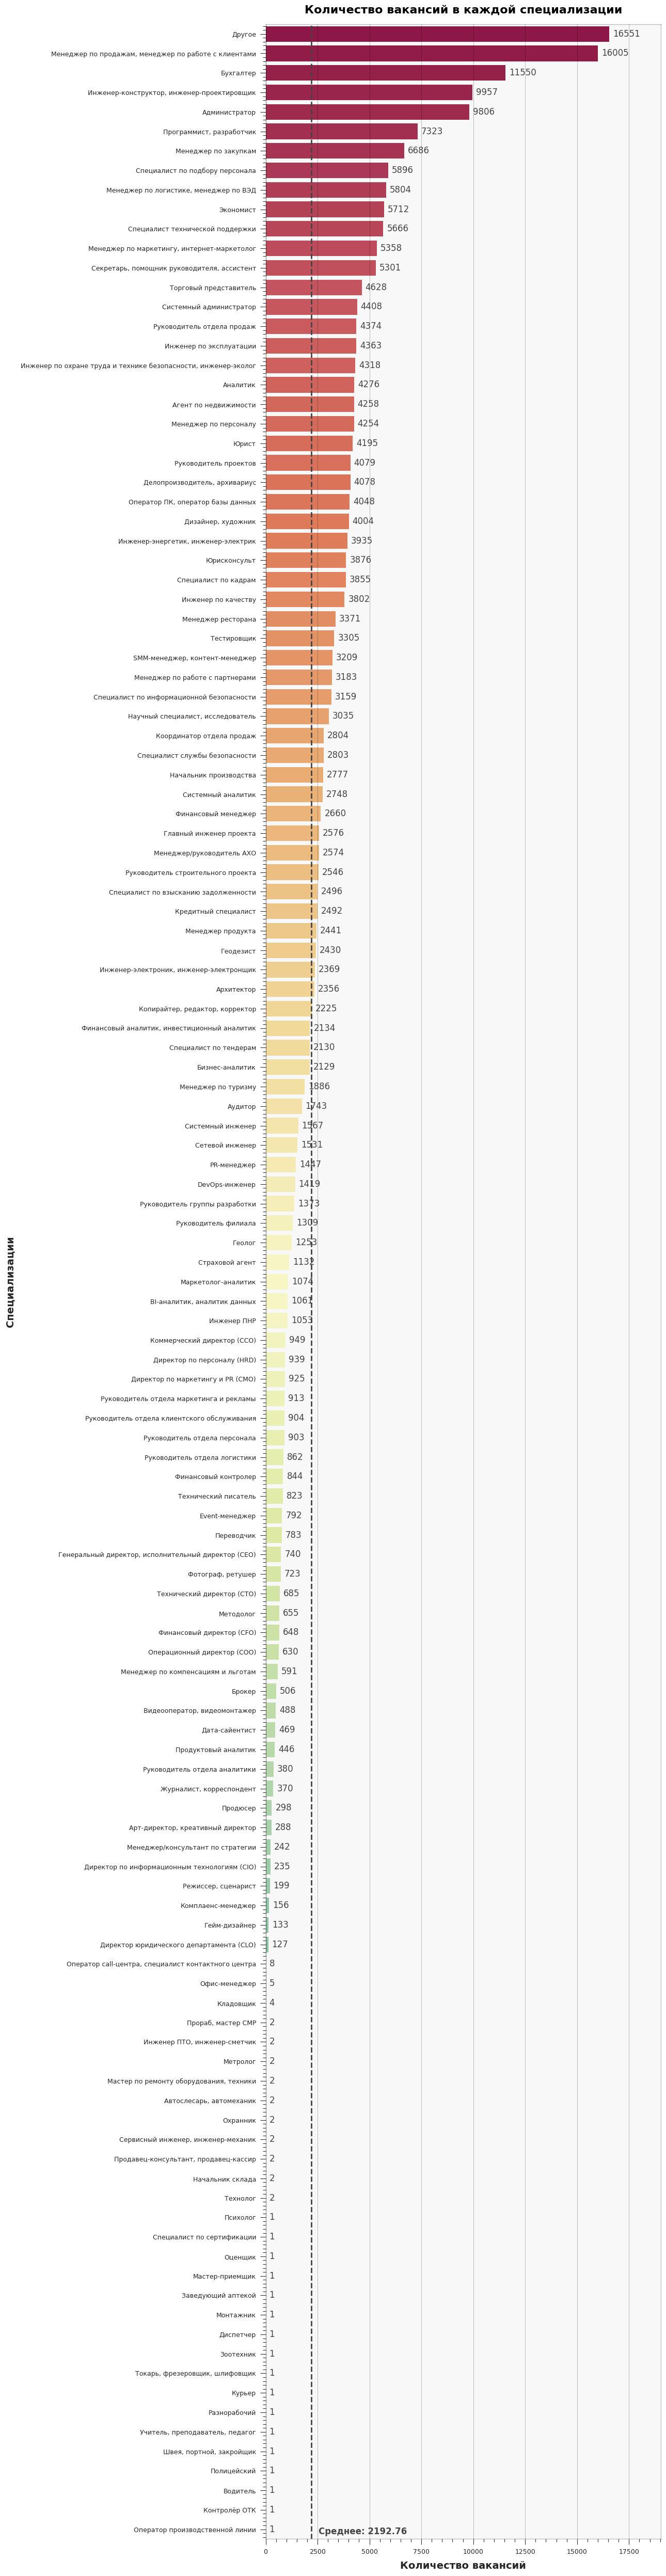

In [12]:
professional_roles = columns[4]

# Подсчет количества вакансий в каждой специализации и сортировка от большего к меньшему
sorted_data = df[professional_roles].value_counts().sort_values(ascending = False)

# Преобразование в DataFrame для использования в Seaborn
sorted_df = pd.DataFrame(sorted_data).reset_index()
sorted_df.columns = [professional_roles, "count"]

# Визуализация
plt.figure(figsize = (13, 50))
ax = sns.barplot(y = professional_roles, x = "count", data = sorted_df, palette = "Spectral")

# Определение максимального значения для оси X и добавление буфера
max_value = sorted_df["count"].max()
buffer = max_value * 0.15

# Устанавливаем диапазон оси X
ax.set_xlim(0, max_value + buffer)

# Добавляем числа справа от каждого столбца
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = "left", va = "center", xytext = (5, 0), textcoords = "offset points", fontsize = 12, color = "#444")

# Настройка заголовка и подписей
plt.title("Количество вакансий в каждой специализации", fontsize = 16, fontweight = "bold")
plt.xlabel("Количество вакансий", fontsize = 14, fontweight = "bold")
plt.ylabel("Специализации", fontsize = 14, fontweight = "bold")

# Добавление сетки
ax.xaxis.grid(True)  # Включение горизонтальной сетки

# Уменьшение отступов и улучшение размещения
plt.tight_layout()

# Добавление аннотации со средним значением
mean_value = sorted_df["count"].mean()
ax.axvline(mean_value, color = "#444", linestyle = "--", linewidth = 2)
ax.annotate(f"Среднее: {mean_value:.2f}", xy = (mean_value, len(sorted_df) - 0.75), 
            xytext = (10, 0), textcoords = "offset points", color = "#444", fontsize = 12, fontweight = "bold", ha = "left")

# Сохранение графика в высоком качестве
plt.savefig("vacancy_specializations.png", dpi = 600, bbox_inches = "tight", pad_inches = 0.1)

# Отображение графика
plt.show()